In [478]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as wb
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from polygon import RESTClient
register_matplotlib_converters()

polygon_api_key = 'nvAUkpEBzFIGbt0wbPTPyiHlMnYpwRT0'
yf.pdr_override()



def data_for_ticker(ticker, start_date, end_date):
    data = wb.DataReader(ticker, start_date, end_date)['Adj Close']
    data = pd.DataFrame({'Close':data})
    data.reset_index(inplace=True, drop=True)
    return data

def calculate_returns(data):
    returns = (data.loc[1:, 'Close'] - \
           data.shift(1).loc[1:, 'Close']) / \
           data.shift(1).loc[1:, 'Close']
    return returns



# prices = pd.DataFrame()
# yf.pdr_override()


#--------------------------------------------------- GEOMETRIC BROWNIAN MOTION ------------------------------------------------

# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in prediction the time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path
ticker = 'SPY'
start_date = datetime(2003,10,1)
end_date = datetime(2023, 2, 17)
#pred_end_date = datetime(2023,4, 17)
num_days_to_predict = 252

S_eon = data_for_ticker(ticker, start_date, end_date)
returns = calculate_returns(S_eon)


[*********************100%***********************]  1 of 1 completed


In [479]:
client = RESTClient(api_key = polygon_api_key)
option_contracts = client.list_options_contracts(underlying_ticker=ticker, contract_type='call', expiration_date='2023-03-17', limit=10, strike_price=408.0)

In [480]:
for c in option_contracts:
    print(c)
    

OptionsContract(additional_underlyings=None, cfi='OCASPS', contract_type='call', correction=None, exercise_style='american', expiration_date='2023-03-17', primary_exchange='BATO', shares_per_contract=100, strike_price=408, ticker='O:SPY230317C00408000', underlying_ticker='SPY')


In [481]:
def run_simulation(data, returns, dt, T, scenarios):

# Parameter Assignments
    So = S_eon.loc[data.shape[0] - 1, "Close"]
   # dt = 1 # day   # User input
    #n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
    #                 format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
    #                 end = pd.to_datetime(pred_end_date, 
    #                 format = "%Y-%m-%d")).to_series().map(lambda x: 
    #                 1 if x.isoweekday() in range(1,6) else 0).sum()
    #T = n_of_wkdays # days  # User input -> follows from pred_end_date
#     T = num_days_to_predict
    N = T / dt
    t = np.arange(1, int(N) + 1)
    mu = np.mean(returns)
    sigma = np.std(returns)
    scen_size = 10000 # User input
    b = {str(scen): np.random.laplace(0, 1, int(N)) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
    # Calculating drift and diffusion components
    drift = (mu - 0.5 * sigma**2) * t
    print(drift)
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
    #print(diffusion)
    # Making the predictions
    S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
    S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series
    return S

In [482]:
S = run_simulation(S_eon, returns, 1, num_days_to_predict, scen_size)


[0.00036066 0.00072131 0.00108197 0.00144262 0.00180328 0.00216393
 0.00252459 0.00288524 0.0032459  0.00360655 0.00396721 0.00432786
 0.00468852 0.00504917 0.00540983 0.00577048 0.00613114 0.00649179
 0.00685245 0.0072131  0.00757376 0.00793441 0.00829507 0.00865572
 0.00901638 0.00937703 0.00973769 0.01009834 0.010459   0.01081965
 0.01118031 0.01154096 0.01190162 0.01226227 0.01262293 0.01298358
 0.01334424 0.01370489 0.01406555 0.0144262  0.01478686 0.01514751
 0.01550817 0.01586882 0.01622948 0.01659013 0.01695079 0.01731144
 0.0176721  0.01803275 0.01839341 0.01875406 0.01911472 0.01947537
 0.01983603 0.02019668 0.02055734 0.02091799 0.02127865 0.0216393
 0.02199996 0.02236061 0.02272127 0.02308192 0.02344258 0.02380323
 0.02416389 0.02452454 0.0248852  0.02524585 0.02560651 0.02596716
 0.02632782 0.02668847 0.02704913 0.02740978 0.02777044 0.02813109
 0.02849175 0.0288524  0.02921306 0.02957371 0.02993437 0.03029502
 0.03065568 0.03101633 0.03137699 0.03173764 0.0320983  0.03245

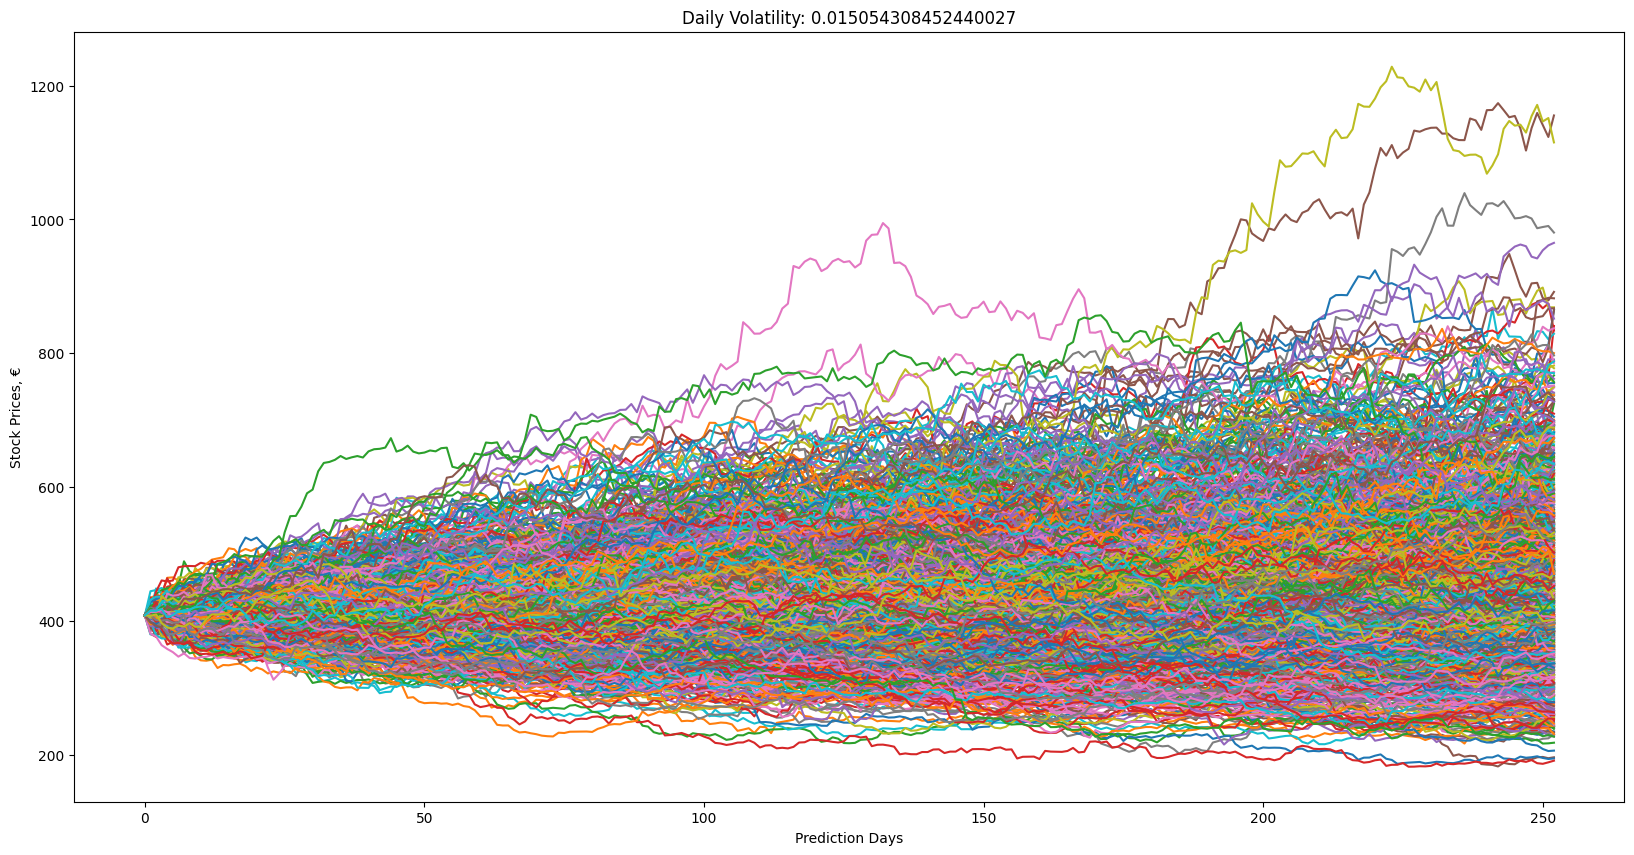

In [483]:
# Plotting the simulations
plt.figure(figsize = (20,10))
for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    #plt.plot(pd.date_range(start = S_eon["Date"].max(), 
    #            end = pred_end_date, freq = 'D').map(lambda x:
    #            x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.plot(S[i,:])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')
plt.show()

In [484]:
# Dataframe format for predictions - first 10 scenarios only
#Preds_df = pd.DataFrame(S.swapaxes(0, 1)[:, :10]).set_index(
#           pd.date_range(start = S_eon["Date"].max(), 
#           end = pred_end_date, freq = 'D').map(lambda x:
#           x if x.isoweekday() in range(1, 6) else np.nan).dropna()
#           ).reset_index(drop = False)
def find_discounted_call_value(prices, dte):
   start = prices[0]
   last = prices[dte-1]
   delta = last-start
   if delta < 0:
       return 0
   else:
       return delta

def find_discounted_put_value(prices, dte):
   start = prices[0]
   last = prices[dte-1]
   delta = last-start
   if delta > 0:
       return 0
   else:
       return abs(delta)


In [497]:
final_change = []
for i in range(0, scen_size):
    pct_change = (S[i, :].min() - S[i, :][0]) / S[i, :][0]
    if pct_change <= -.1:
        final_change.append(1)
    else:
        final_change.append(0)
        
pct_changes_predicted = pd.DataFrame(final_change)
print(pct_changes_predicted.mean())
# option_values = np.zeros(scen_size)
# put_values = np.zeros(scen_size)
# plt.figure(figsize = (20,10))
# plt.plot(pct_changes_predicted)

for i in range(0, scen_size):
    option_values[i] = find_discounted_call_value(S[i,:], 252)
    put_values[i] = find_discounted_put_value(S[i, :], 252)

0    0.565
dtype: float64


In [486]:
expected_value = option_values.mean() / 2
print(expected_value)
expected_put_value = put_values.mean() / 2 
print(expected_put_value)

39.6732039703037
12.825381625447632


In [487]:
implied_volatity = wb.DataReader

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

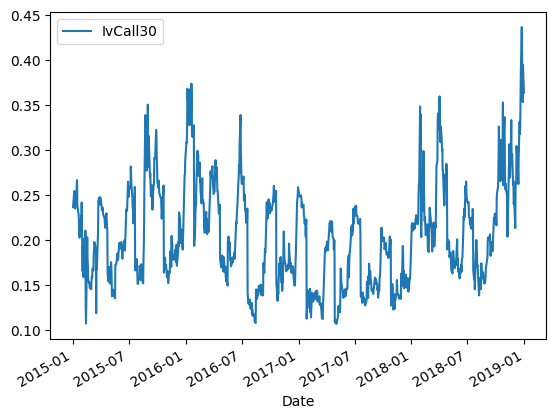

In [488]:
quandl.ApiConfig.api_key = 'huv3fvMvihS6f9KGszyT'
iv_data = quandl.get('VOL/MSFT', start_date='2015-01-01', end_date='2018-12-31')
#stock_data = data_for_ticker('MSFT', start_date = '2015-01-01', end_date = '2018-12-31')
start = datetime(2015,1,1)
end = datetime(2018,12,31)
stock_data = wb.DataReader(ticker, start, end)['Adj Close']
stock_data = pd.DataFrame({'Close':stock_data})
#combined = pd.DataFrame({'Underlying':stock_data, "ATM Call IV 30": iv_data})
combined = pd.concat([iv_data.loc[:, ["IvCall30"]], stock_data], axis=1)
#fig = plt.figure()
# ax1 = plt.add_axes([.1,.5,.8,.4],ylim=(100,300))
# ax2 = plt.add_axes([.1,.1,.8,.4],ylim=(0,1))
# ax1.plot(stock_data)
# ax2.plot(iv_data)
iv_data.loc[:, ["IvCall30"]].plot()

<Axes: xlabel='Date'>

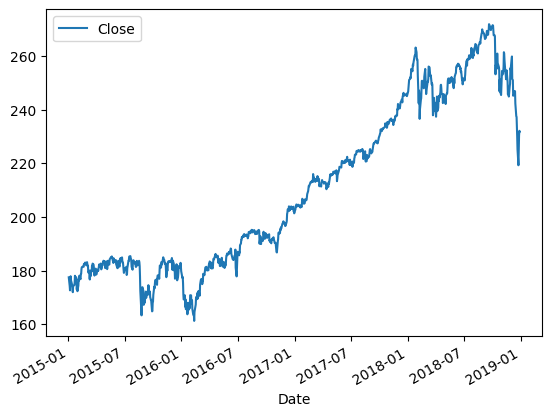

In [489]:
stock_data.plot()